In [1]:
import os
import time
import random
import collections

import gym
from gym import wrappers
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
from utilities.models import DQN
from utilities.utils import mkdir, live_plot

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

---
---
---

##### Environment

In [3]:
env_name = 'LunarLander-v2'
save_models = True
seed = 11

##### Initialize environment and set seeds

In [4]:
env = gym.make(env_name)

env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

##### Create folder in which trained models will be saved

In [6]:
if all([save_models, not os.path.exists('./pytorch_models')]):
    os.makedirs('./pytorch_models')
if all([save_models, not os.path.exists('./pytorch_models/all_dqn')]):
    os.makedirs('./pytorch_models/all_dqn')

In [7]:
file_name = f'DQN_{env_name}_{seed}'
print(file_name)

DQN_LunarLander-v2_11


##### Initialize agent parameters

In [8]:
buffer_size = 1e6
batch_size = 64

gamma = 0.99
tau = 5e-3
policy_freq = 3
lr = 1e-3
epochs = 20

##### Initialize agent

In [10]:
agent = DQN(
    state_dim, 
    action_dim, 
    eta=lr,
)


---

##### Initialize training variables 

In [12]:
#agent.load(file_name, './pytorch_models')

In [13]:
max_steps = 1000 # Max steps per episode

episodes = 700 #1500
total_steps = 0
report = 20

expl_rate = 0.99

In [14]:
reward_trace = collections.defaultdict(list)

##### Plot noise decay

In [15]:
def noise_decay(eta, step, decay=2e-4):
    return eta * 1/(decay*step + 1)

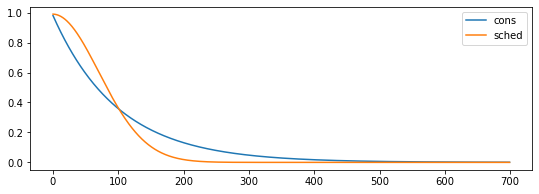

In [16]:
trace, trace_ = [], []
eta = eta_ = expl_rate

for i in np.arange(episodes):
    eta = noise_decay(eta, i, decay=2e-4)
    eta_ *= 0.99

    trace.append(eta)
    trace_.append(eta_)
    
plt.figure(figsize=(9,3))
plt.plot(trace_, label='cons')
plt.plot(trace, label='sched')
plt.legend()
plt.show()

##### Training:

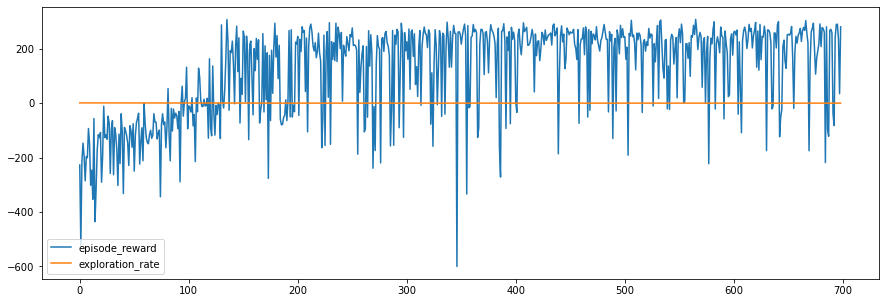

In [17]:
for episode in np.arange(1, episodes):             
    
    obs = env.reset()
    done = False
    episode_reward = []
    steps = 0
    
    
    
    while not done:        
            
        if np.random.random() < expl_rate:
            action = env.action_space.sample()
        else:
            action = agent.select_action(np.array(obs))
                            
        new_obs, reward, done, info = env.step(action)
        
        done = (done) or (steps >= max_steps)

        episode_reward.append(reward)
        agent.replay_buffer.add((obs, new_obs, action, reward, int(done)))
        
        obs = new_obs
        steps += 1
        total_steps += 1


        
    agent.train(steps, batch_size, gamma, tau, policy_freq)
    expl_rate = noise_decay(expl_rate, episode).round(9)
    
    reward_trace['episode_reward'].append(sum(episode_reward))
    reward_trace['exploration_rate'].append(expl_rate)
                    
    ax = live_plot(reward_trace)
    plt.show()
    
    if episode % report == 0:
        
        print('Episode:', episode)
        print('Average score:', np.mean(reward_trace['episode_reward'][-report:]))
        print('Exploration rate:', reward_trace['exploration_rate'][-1])
        time.sleep(1)
        
        agent.save(
            f'{file_name}_{episode}', 
            './pytorch_models/all_dqn',
        )
        

In [18]:
total_steps

252987

In [19]:
episode

699

In [21]:
expl_rate

4e-09

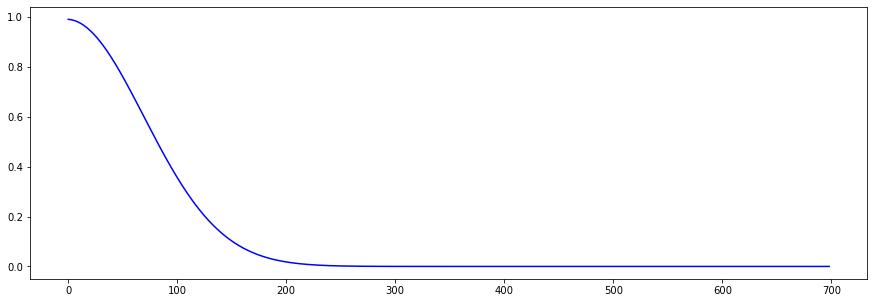

In [22]:
plt.figure(figsize=(15,5))
plt.plot(reward_trace['exploration_rate'], 'b')
plt.show()

##### Plot reward trace

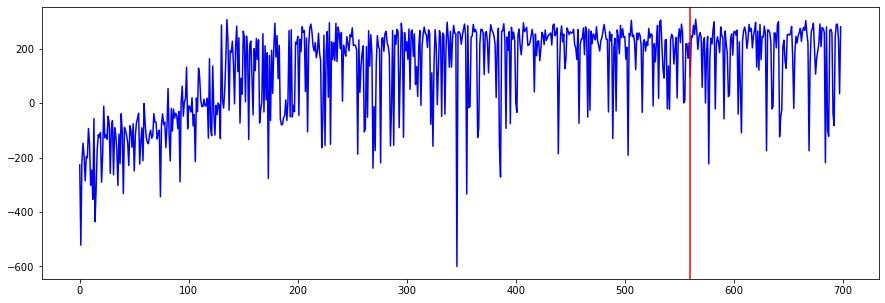

In [26]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['episode_reward'], 'b')
#plt.plot(reward_trace['episode_reward'][:10], 'r')

plt.axvline(report*28, c='r')
plt.show()

##### Save only model from selected point in training history

In [28]:
idx = 560

agent.load(
    f'{file_name}_{idx}', 
    './pytorch_models/all_dqn',
)

agent.save(
    file_name, 
    './pytorch_models',
)

for item in os.listdir('./pytorch_models/all_dqn'):
    os.remove(os.path.join('./pytorch_models/all_dqn', item))

---

In [33]:
agent.load(file_name, './pytorch_models')

In [34]:
max_steps = 1000 # Max steps per episode
episodes = 500
report = 10

In [35]:
reward_trace = collections.defaultdict(list)

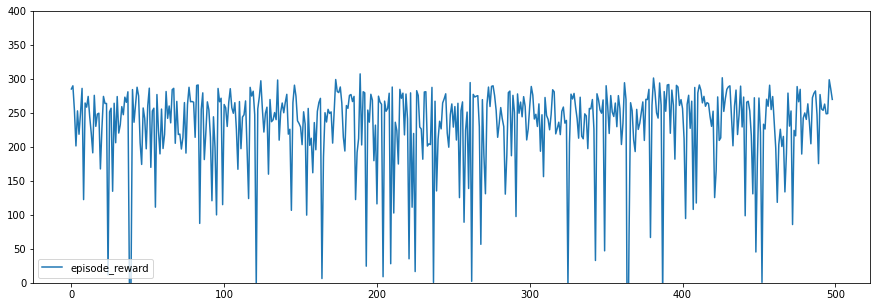

In [36]:
for episode in np.arange(1, episodes):             
    
    obs = env.reset()
    done = False
    episode_reward = []
    steps = 0
    
    
    
    while not done:        
        
        action = agent.select_action(np.array(obs))
                
        new_obs, reward, done, info = env.step(action)
        
        done = (done) or (steps >= max_steps)
        
        episode_reward.append(reward)
        
        obs = new_obs
        steps += 1


    
    reward_trace['episode_reward'].append(sum(episode_reward))
    ax = live_plot(reward_trace)
    ax.set_ylim([0, 400])
    plt.show()
    
    if episode % report == 0:
        
        print('Episode:', episode)
        print('Average score:', np.mean(reward_trace['episode_reward'][-report:]))
        time.sleep(1)
        
    

In [38]:
np.mean(reward_trace['episode_reward'])

230.56810564034419